In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *

from alvra_tools.XAS_functions import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

## choose the run number

In [2]:
pgroup='p21005'
runnumber = 115

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0115


'/sf/alvra/data/p21005/raw/run0115-D4PY_Timescan_7123eV_6uJ/meta/scan.json'

# Single scan, WITHOUT TT correction

In [3]:
quantile_corr = 0.5

detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES_timescans/'
saveflag = False

#######################################################################################################33
from sfdata import SFScanInfo
try:
    scan = SFScanInfo(jsonfile)
    scan = remove_JF_from_scan(scan)
    flag = False

    Timezero_mm = 147.4889
    try:
        flag = True
        Timezero_mm = get_timezero_NBS(jsonfile)
    except:
        Timezero_mm = Timezero_mm

    (DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, 
     DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, 
     Izero_pump, Izero_unpump, correlation1, correlation2, readbacks, goodshots1, goodshots2) = \
    XAS_scanPP_2diodes_noTT(scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr)

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))

    Delay_mm, Delay_fs = adjust_delayaxis(scan,readbacks,Timezero_mm)

    run_name = jsonfile.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)
    if saveflag:
        save_data_timescans_2diodes(reducedir, run_name, Delay_mm, Delay_fs,
                                DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1,
                                DataDiode2_pump, DataDiode2_unpump, Pump_probe_Diode2, goodshots2)
except:
    print ('==> json file not yet ready!! <==')

Processing: run0115-D4PY_Timescan_7123eV_6uJ
Step 27 of 27: Processing acq0027

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet      1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH1_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES12-GES1:PR1_CH2_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY     995 / 1001 -> 1% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 995 / 1001 -> 1% loss
complete channels: 3 / 4 -> 25% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 489 pump and 489 unpump shots
125 shots out of 489 survived
128 shots out of 489 survived
Step 27 of 27: Processed acq0027
correlation Diode1 (all shots) = -0.04374152056664191
correlation Diode2 (all shots) = 0.9918776837497244
------------------------------
Processed 27 out of 27 files
-----------------------------

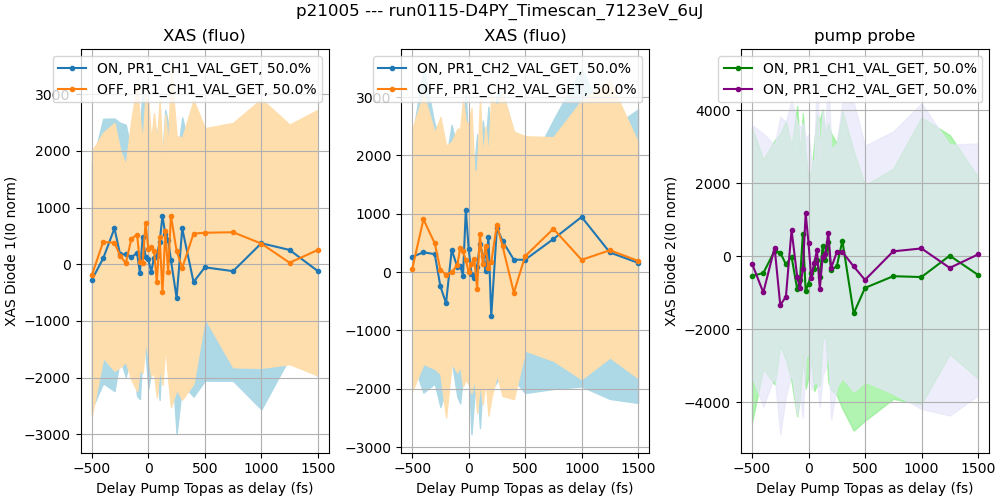

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)

#Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS1_pump = DataDiode1_pump[:,0]
err1_low_pump = DataDiode1_pump[:,1]
err1_high_pump = DataDiode1_pump[:,2]
XAS1_unpump = DataDiode1_unpump[:,0]
err1_low_unpump = DataDiode1_unpump[:,1]
err1_high_unpump = DataDiode1_unpump[:,2]
XAS1_pump_probe = Pump_probe_Diode1[:,0]
err1_low_pump_probe = Pump_probe_Diode1[:,1]
err1_high_pump_probe = Pump_probe_Diode1[:,2]

XAS2_pump = DataDiode2_pump[:,0]
err2_low_pump = DataDiode2_pump[:,1]
err2_high_pump = DataDiode2_pump[:,2]
XAS2_unpump = DataDiode2_unpump[:,0]
err2_low_unpump = DataDiode2_unpump[:,1]
err2_high_unpump = DataDiode2_unpump[:,2]
XAS2_pump_probe = Pump_probe_Diode2[:,0]
err2_low_pump_probe = Pump_probe_Diode2[:,1]
err2_high_pump_probe = Pump_probe_Diode2[:,2]

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

ax1.plot(Delay_fs, XAS1_pump, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_pump, err1_high_pump, color='lightblue')

ax1.plot(Delay_fs, XAS1_unpump, label='OFF, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),marker='.')
ax1.fill_between(Delay_fs, err1_low_unpump, err1_high_unpump, color='navajowhite')

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

ax2.plot(Delay_fs, XAS2_pump, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_pump, err2_high_pump, color='lightblue')

ax2.plot(Delay_fs, XAS2_unpump, label='OFF, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),marker='.')
ax2.fill_between(Delay_fs, err2_low_unpump, err2_high_unpump, color='navajowhite')

ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_title('XAS (fluo)')
ax2.legend(loc="best")
ax2.grid()

ax3.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
ax3.fill_between(Delay_fs, err1_low_pump_probe, err1_high_pump_probe, alpha = 0.7, color='lightgreen')
#ax3.plot(Delay_fs, pp_fit, color = 'red', label='risetime = {:.2f} fs'.format(np.abs(width_fs)))

ax3.plot(Delay_fs, XAS2_pump_probe, label='ON, {}, {}%'.format(detector_XAS_2.split(':')[-1], quantile_corr*100),color='purple',marker='.')
ax3.fill_between(Delay_fs, err2_low_pump_probe, err2_high_pump_probe, alpha = 0.7, color='lavender')

ax3.set_xlabel("{} ({})".format(label, units))
ax3.set_ylabel ("XAS Diode 2(I0 norm)")
ax3.set_title('pump probe')
ax3.legend(loc="best")
ax3.grid()

# ax1.set_ylim(1.068, 1.10)
# ax2.set_ylim(0.985, 1.015)eV
# ax3.set_ylim(-0.005, 0.02)
# for ax in [ax1, ax2, ax3]:
#     ax.set_xlim(-3000, 10000)

plt.show()

#print(Delay_fs[0],Delay_fs[-1])

In [5]:
fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS1_pump_probe)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_fs,XAS1_pump_probe)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,3)),"fs")
#print("Position t0 =",np.round(t0_fs,5),"fs")
#print("Width =",np.abs(np.round(width_fs,5)),"fs")

Position t0 = 213.54976 fs
Width = 4.063 fs


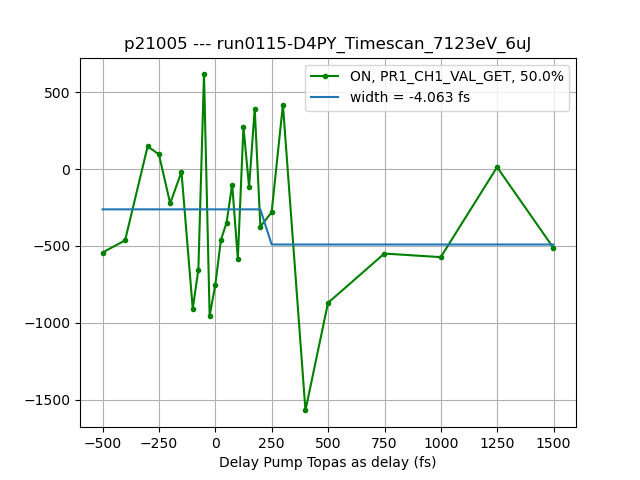

In [6]:
plt.figure()
plt.title(titlestring)
plt.plot(Delay_fs, XAS1_pump_probe, label='ON, {}, {}%'.format(detector_XAS_1.split(':')[-1], quantile_corr*100),color='green',marker='.')
plt.plot(Delay_fs, pp_fit, label = 'width = {:.3f} fs'.format(width_fs))
plt.legend(loc='best')
plt.xlabel("{} ({})".format(label, units))
plt.grid()
plt.show()

## Error Bars

In [7]:
#### CH1 ####
XAS1_pump      = DataDiode1_pump[:,0]
err1_low_pump  = (DataDiode1_pump[:,1]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)
err1_high_pump = (DataDiode1_pump[:,2]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)

XAS1_unpump      = DataDiode1_unpump[:,0]
err1_low_unpump  = (DataDiode1_unpump[:,1]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)
err1_high_unpump = (DataDiode1_unpump[:,2]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)

XAS1_pump_probe       = Pump_probe_Diode1[:,0]
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

#### CH2 ####
XAS2_pump        = DataDiode2_pump[:,0]
err2_low_pump    = (DataDiode2_pump[:,1]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)
err2_high_pump   = (DataDiode2_pump[:,2]-DataDiode2_pump[:,0])/np.sqrt(goodshots2)

XAS2_unpump      = DataDiode2_unpump[:,0]
err2_low_unpump  = (DataDiode2_unpump[:,1]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)
err2_high_unpump = (DataDiode2_unpump[:,2]-DataDiode2_unpump[:,0])/np.sqrt(goodshots2)

XAS2_pump_probe       = Pump_probe_Diode2[:,0]
err2_low_pump_probe   = np.sqrt(err2_low_pump**2  + err2_low_unpump**2)
err2_high_pump_probe  = np.sqrt(err2_high_pump**2 + err2_high_unpump**2)

# Averaging 2 diodes

In [8]:
XAS_mean_pump = (XAS1_pump+XAS2_pump)/2
XAS_mean_unpump = (XAS1_unpump+XAS2_unpump)/2

offset1 = np.average(XAS1_unpump[0:5])
offset2 = np.average(XAS2_unpump[0:5])

ave_unpump = (XAS1_unpump-offset1 + XAS2_unpump-offset2)/2
ave_unpump_err_l = np.sqrt(err1_low_unpump**2+err2_low_unpump**2)
ave_unpump_err_h = np.sqrt(err1_high_unpump**2+err1_high_unpump**2)

ave_pump = (XAS1_pump-offset1 + XAS2_pump-offset2)/2
ave_pump_err_l = np.sqrt(err1_low_pump**2+err2_low_pump**2)
ave_pump_err_h = np.sqrt(err1_high_pump**2+err1_high_pump**2)

##Average first, subtract later
ave_pp1 = ave_pump - ave_unpump
#ave_pp_err1 = np.sqrt((ave_unpump_err_h-ave_unpump_err_l)**2+np.square(ave_pump_err_h-ave_pump_err_l)**2)
ave_pp_err_l1 = np.sqrt(ave_unpump_err_l**2+ave_pump_err_l**2)
ave_pp_err_h1 = np.sqrt(ave_unpump_err_h**2+ave_pump_err_h**2)

##Average of the difference signals
factor = 1
ave_pp2 = (XAS1_pump_probe*factor + XAS2_pump_probe*factor)/2
ave_pp_err_l2 = ((err1_low_pump_probe + err2_low_pump_probe)/2)*factor
ave_pp_err_h2 = ((err1_high_pump_probe + err2_high_pump_probe)/2)*factor

# Plotting Averged Diodes with error bars

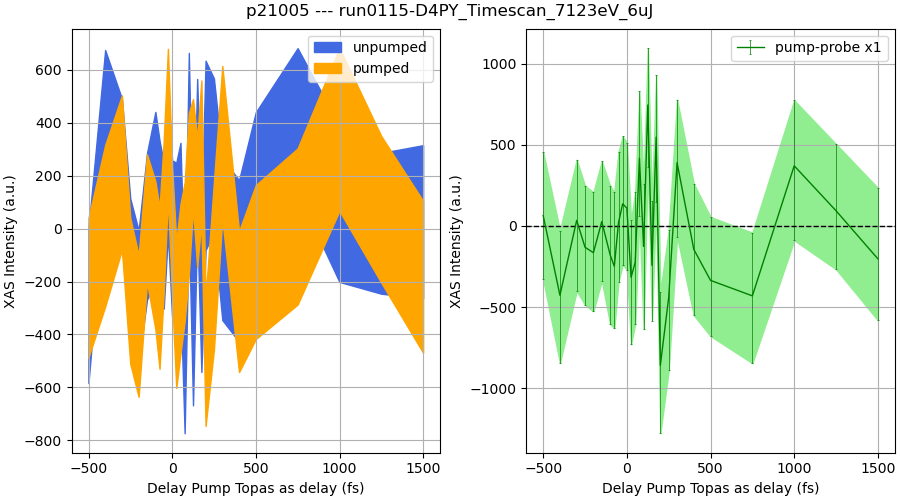

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)

# ax1.axes.errorbar(Delay_fs,ave_unpump, ave_unpump_err_l ,ave_unpump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='unpumped')
# ax1.axes.errorbar(Delay_fs, ave_pump,  ave_pump_err_l,  ave_pump_err_h, 
#              lw=1,marker='o',markersize=3,capsize=2,label='pumped')

#ax1.plot(Delay_fs,ave_unpump,lw=1,marker='o',markersize=3,label='unpumped')
units = scan.parameters['units'][0]
ax1.fill_between(Delay_fs,ave_unpump-ave_unpump_err_l, ave_unpump+ave_unpump_err_h,color='royalblue',label='unpumped')
ax1.fill_between(Delay_fs,ave_pump-ave_pump_err_l, ave_pump+ave_pump_err_h,color='orange',label='pumped')

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.grid()
ax1.legend(loc='best')
#ax1.set_xlim(-400,900)

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Delay_fs, ave_pp1, (ave_pp_err_l1, ave_pp_err_h1), 
             lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                  ecolor='green',elinewidth=0.5,label='pump-probe x{}'.format(factor))
#ax2.plot(Delay_fs,ave_pp1,lw=1,marker='o',markersize=3,color='green',label='unpumped')
ax2.fill_between(Delay_fs,ave_pp1-ave_pp_err_l1, ave_pp1+ave_pp_err_h1,color='lightgreen')

ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_ylabel('XAS Intensity (a.u.)')
ax2.grid()
ax2.legend(loc='best')
#ax2.set_xlim(-400,400)



## Check correlation for a certain delay point

In [15]:
chosen_delay_fs = 499

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

quantile_corr = 0.6
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_delay = np.arange(len(Delay_fs))[(Delay_fs > chosen_delay_fs)][0]

Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, correlation_filter = \
Get_correlation_from_scan2(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

arrays_to_filter = ["Fluo_pump", "Fluo_unpump", "Izero_pump", "Izero_unpump"]
arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, globals_dict=globals())

# (Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
#  Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
# Get_correlation_from_scan(scan, index_delay, detector_XAS, detector_Izero, quantile_corr)

print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))

print ('Delay = {:.2f} fs'.format(Delay_fs[index_delay]))

Correlation (all shots)      = 0.08225163153004704
Correlation (filtered shots) = 0.26422115797758056
Delay = 499.33 fs


In [16]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 150.17866307535797, Median (filtered) = 78.33898015486353
MAD (all) = 3106.0431395947053, MAD(filtered) = 3192.267218443849
MAD/median (all) = 2068.2319818202986%, MAD/median (filtered) = 4074.940996338287%


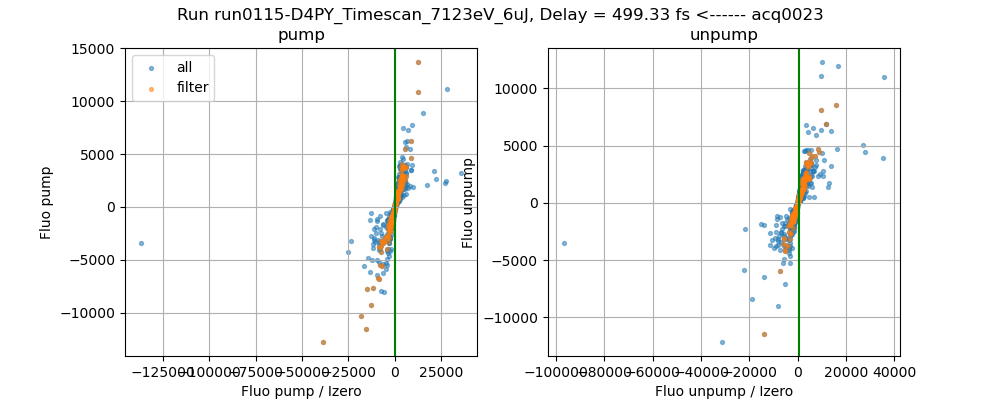

In [17]:
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)

plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.legend(loc='best')
plt.xlabel('Fluo pump / Izero')
plt.ylabel('Fluo pump')
plt.grid()

m_median_filter = np.median(Fluo_unpump_filter/Izero_unpump_filter)

plt.subplot(122)
plt.title('unpump')
plt.scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all')
plt.scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
plt.axvline(x=m_median_filter, color = 'green')
plt.xlabel('Fluo unpump / Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()

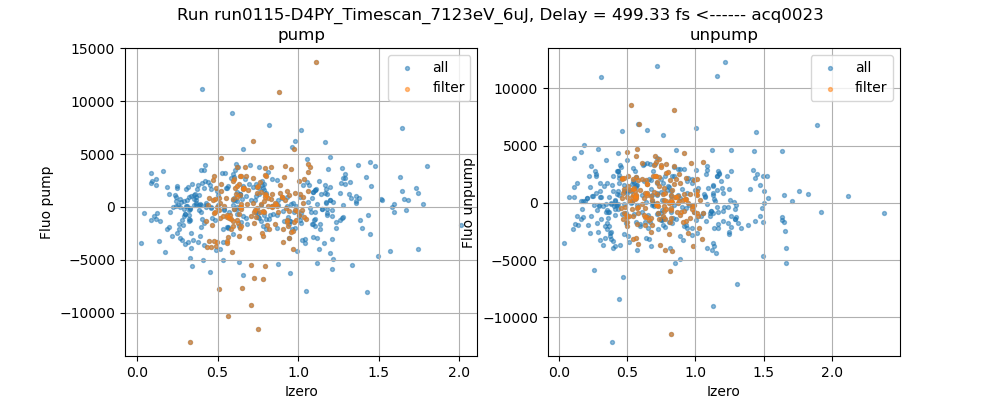

In [18]:
plt.figure(figsize=(10,4))
plt.suptitle('Run {}, Delay = {:.2f} fs <------ {}'.format(jsonfile.split('/')[-3],Delay_fs[index_delay], scan.files[index_delay][1].split('/')[-1].split('.')[0]))
plt.subplot(121)
plt.title('pump')
plt.scatter(Izero_pump, Fluo_pump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_pump_filter, Fluo_pump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo pump')
plt.grid()

plt.subplot(122)
plt.title('unpump')
plt.scatter(Izero_unpump, Fluo_unpump, s = 8, alpha=0.5, label='all')
plt.scatter(Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha=0.5, label='filter')
plt.legend(loc='best')
plt.xlabel('Izero')
plt.ylabel('Fluo unpump')
plt.grid()
plt.show()